<div align="center">
    <H1>
        <Strong>
            Analysis on Hero Compositions in Professional Overwatch
        </Strong>
    </H1>
    Chinhnam Nguyen, Jared Fleming, Ben Fleming
</div>

---

<div align="center">
    <H1>
        <Strong>
            Introduction
        </Strong>
    </H1>
</div>

Overwatch is a multiplayer team-based first-person shooter developed and published by Blizzard Entertainment and published in 2016. It skyrocketed in popularity quickly after release and is still going strong with over 5 million average players each month in 2021, and peaking as high as 7.3 million. Described as a "hero shooter", Overwatch assigns players into two teams of six, with each player selecting from a large roster of characters, known as "heroes", with unique abilities. Teams work to complete map-specific objectives within a limited period of time such as pushing a payload across the map or holding an area longer than the other team.

The meteoric rise in popularity also inspired both Blizzard and esports organizations to arrange their own teams and tournaments, resulting in the Overwatch League, which is produced and regulated by Blizzard themselves. Though based in the U.S., the league also features teams from Asia and Europe, resulting in 20 city-based teams, each with a max roster of 12 players. Due to its wide interchangeability between maps, gamemodes, and hero compositions (the heroes picked by each team), Overwatch is one of the most analyzed competitive games in the world. To help with this, Blizzard compiles and publicly releases the data collected throughout professional play during the year. All of the datasets can be accessed [here](https://overwatchleague.com/en-us/statslab "Overwatch League Stats Lab").

Here, we will be focusing on the data collected during the 2020 Overwatch League season, and will primarily intend to figure out the most optimal hero compositions for each map and gamemode. Heroes are meant to compliment and check each other as they are split into three classes: damage, support, and tank. Obviously, we would expect a team of six attack heroes to succeed in aggressing the enemy, but would also expect them to fail miserably when defending an area. This is why finding a correct and balanced composition is integral to the game, and professional play in general.

<center><img src="pictures/gallery.jpg" alt="Hero's Gallery" width="700"></center>

<div align="center">
      <Strong>
          Gallery of Overwatch Heroes
      </Strong>
</div>

---

<div align="center">
    <H1>
        <Strong>
            Exploring the Datasets
        </Strong>
    </H1>
</div>

<H3>
    <Strong>
        Libraries
    </Strong>
</H3>

We will be utilizing Python 3 along with various data science libraries: [pandas](https://pandas.pydata.org/), [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/), [sklearn](https://scikit-learn.org/stable/), and more

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import model_selection
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f
import warnings
warnings.filterwarnings('ignore')

<H3>
    <Strong>
        Overview of the Datasets
    </Strong>
</H3>

Luckily for us, Blizzard publically releases the data for the Overwatch League every year. For this study we will be analyzing the 2020 competitive year, which includes one dataset for the players and one dataset regarding the maps/matches played. The player dataset will provide us with player performances on different maps and as different heroes, as well as record their statistics for each map such as damage done and final blows. The maps dataset records each game of a series played, the gamemode and map it was played on, the assigned attacking and defending teams, and winner/loser, and the overall round statistics. We will be using both of these in conjunction to analyze the efficiency of players and certain hero compositions for each gamemode and map.

<H3>
    <Strong>
        Processing the Player Data
    </Strong>
</H3>

Due to its immense size (over 1.2 million rows), Blizzard released the player data for 2020 in two files, one for the first half and the other for the second half. To prepare the data for processing, we will first combine the two datasets. The dataset comes in the form of two CSV files.

In [2]:
# Reading in both datasets and combine into one dataframe
players1, players2 = pd.read_csv("phs_2020/phs_2020_1.csv"), pd.read_csv("phs_2020/phs_2020_2.csv")
data = pd.concat([players1, players2])
data.head()

,start_time,esports_match_id,tournament_title,map_type,map_name,player_name,team_name,stat_name,hero_name,stat_amount
0,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,All Damage Done,All Heroes,6674.164055
1,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Assists,All Heroes,11.000000
2,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Average Time Alive,All Heroes,60.199502
3,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Barrier Damage Done,All Heroes,1875.000000
4,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Damage Blocked,All Heroes,14640.911780


We can see that the raw dataset present us with a myriad of problems. Firstly, it includes data collected outside of the OWL 2020 Regular Season, which we will not be considering. Another issue is that `stat_name` is presented as it's own column instead of their own individual and respective columns. This will make it difficult for us to understand and view the dataset as well as accessing player statistics. We will be dropping the `start_time` column as it is irrelevant to what we are depicting, along with all rows that record the cumulative statistics for a player on all heroes (`hero_name == All Heroes`), since we are looking to compare individual hero statistics. To make things simpler, we will conglomerate a player's stats with a hero across games in a match, meaning if a player plays as a hero more than once for the same `match_id`, we will average their statistics across the games into one row. The dataset also includes a multitude of irrelevant statistics that we will need to remove, such as `Environmental Kills` i.e. number of times the player knocks an enemy off of the map. To recap, there are five things we need to do to sanitize the data:
1. Drop all non OWL 2020 Regular Season rows
2. Pivot the table to turn stat_name into columns with stat_amount as values
3. Drop `start_time`
4. Drop all `hero_name == All Heroes` rows
5. Drop all irrelevant statistics

<H3>
    <Strong>
        Tidying the Player Dataset
    </Strong>
</H3>

First, lets drop all irrelevant columns and rows and rearrange the columns into a more readable format.

In [3]:
# Drop irrelevant columns and rows
data.drop(['start_time'], axis=1)
data.drop(data.index[data['tournament_title'] != 'OWL 2020 Regular Season'], inplace=True)
data.drop(['tournament_title'], axis = 1, inplace = True)
data = data.reindex(columns = ['esports_match_id', 'map_type', 'map_name', 'player_name', 'team_name', 'hero_name', 'stat_name', 'stat_amount'])
data = data[data["hero_name"] != "All Heroes"]
stats = ['Hero Damage Done', 'Assists', 'Barrier Damage Done', 'Deaths', 'Eliminations', 'Objective Kills', 'Objective Time', 'Ultimates Earned - Fractional', 'Final Blows', 'Damage Blocked', 'Healing Done', 'All Damage Done']
data = data.loc[data['stat_name'].isin(stats)]
data['stat_amount'] = data['stat_amount'].round(decimals = 2)
data.head()

,esports_match_id,map_type,map_name,player_name,team_name,hero_name,stat_name,stat_amount
22,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,All Damage Done,6674.16
23,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Assists,11.00
25,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Barrier Damage Done,1875.00
31,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Damage Blocked,14640.91
33,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Deaths,5.00


The dataframe already looks much better but we're not done yet. Now we can pivot the table to turn `stat_name` into columns and `stat_amount` into rows.

In [4]:
# Tidy dataset to elongate stat_name column into rows and insert respective stat_amount values
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']].copy().reset_index()
data = data.pivot_table(values='stat_amount', index=[data['esports_match_id'],data['team_name'], data['player_name'], data['map_name'], data['hero_name']], columns='stat_name', aggfunc='sum')
data = data.fillna(0).reset_index()
data.rename(columns = {'Ultimates Earned - Fractional':'Ultimates Earned', 'esports_match_id':'match_id'}, inplace = True)
data['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
data.head()

stat_name,match_id,team_name,player_name,map_name,hero_name,All Damage Done,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,14495.63,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,9921.49,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,12362.02,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,6674.16,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,12012.14,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03


Here, we can see that the finalized dataset we will be analyzing has five objective columns and twelve stat columns and a total of 24,951 rows. 
<Strong>Objective Columns:</Strong>
* `match_id` - The number referencing the matches in which the player earned the stats. A series of matches will have the same match_id.
* `team_name` - Name of the team of the player.
* `player_name` - In-game name of the player.
* `map_name` - Names of the maps on which the games were played.
* `hero_name` - Names of the heroes that the player played as.

<Strong>Stat Columns:</Strong>
* `All Damage Done` - Total damage done by the player in the match.
* `Assists` - Enemy deaths that the player participated in but did not achieve the final blow.
* `Barrier Damage Done` - Damage done by player only to enemy barriers.
* `Damage Blocked` - Damage blocked by the player's barriers (will only apply to barrier heroes).
* `Deaths` - Total death count of the player.
* `Eliminations` - Total number of enemy deaths that the player participated in.
* `Final Blows` - Enemy deaths in which the player achieved the final blow.
* `Healing Done` - Total personal and team health points healed by the player (will only apply to healing heroes).
* `Hero Damage Done` - Damage done only to enemy heroes.
* `Objective Kills` - Eliminations made by the player where the enemy was either at the objective point, or the player was defending the objective point.
* `Objective Time` - Time spent by the player either defending or attacking the objective point.
* `Ultimates Earned` - Total ultimate abilities earned by the player.

Now, we can easily transform the player dataframe and access stat values as necessary!

<center><img src="pictures/pros.jpeg" alt="Hero's Gallery" width="600"></center>

<div align="center">
      <Strong>
          Overwatch League's Finest
      </Strong>
</div>

<H3>
    <Strong>
        Processing the Maps Data
    </Strong>
</H3>

The maps dataset requires far less work to tidy than the players dataset. It can be found at the same website as the players data and comes in the form of a single CSV file.

In [5]:
maps = pd.read_csv("phs_2020/match_map_stats.csv")
maps.head()

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,Los Angeles Valiant,San Francisco Shock,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,Los Angeles Valiant,San Francisco Shock,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2


We can see that the maps dataset comes with 25 columns, most of which are not necessary for what we are looking at. As a result, we will remove the unncessary columns, meaning we will only keep ```match_id```, ```team_one_name```, ```team_two_name```, ```map_name```, ```map_winner```, ```game_number```, and ```match_winner```. The only issue is each Overwatch game has multiple rounds within each game, so the data has rows for each teams attack and defense or overtime. These excessive rows are not needed because all of the rows display the same team names, map winner, and match winner, so we can drop these duplicate rows.

In [6]:
maps['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
cleaned_maps = pd.DataFrame()
# Only takes match id of 2020 season games which is between match ids of 30991 and 36231 from the player data table
maps.query("`match_id` >= 30991", inplace = True)
maps.query("`match_id` <= 36231", inplace = True)
cleaned_maps = pd.DataFrame(maps, columns = ['match_id', 'team_one_name', 'team_two_name', 'map_winner', 'map_name', 'game_number', 'match_winner'])
# Only took necessary columns
cleaned_maps.rename(columns = {'team_one_name': 'team_one', 'team_two_name': 'team_two'}, inplace = True)
cleaned_maps.drop_duplicates(inplace = True)
cleaned_maps.head()

,match_id,team_one,team_two,map_winner,map_name,game_number,match_winner
6246,30991,Toronto Defiant,Paris Eternal,Paris Eternal,Lijiang Tower,1,Toronto Defiant
6248,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Eichenwalde,2,Toronto Defiant
6252,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Horizon Lunar Colony,3,Toronto Defiant
6255,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Havana,4,Toronto Defiant
6257,30992,London Spitfire,New York Excelsior,London Spitfire,Lijiang Tower,1,New York Excelsior


Now, we see that there are not many visibile errors except ```team_one``` and ```team_two``` are able to switch which name comes first in the two columns, so we can fix that by arranging them in alphabetical order.

In [10]:
new_frame = pd.DataFrame(columns = cleaned_maps.columns)
for index, row in cleaned_maps.iterrows():
    if row['team_two'] < row['team_one']:
        new_frame.loc[index] = [row['match_id'], row['team_two'], row['team_one'], row['map_winner'], row['map_name'], row['game_number'], row['match_winner']]
    else:
        new_frame.loc[index] = [row['match_id'], row['team_one'], row['team_two'], row['map_winner'], row['map_name'], row['game_number'], row['match_winner']]
cleaned_maps = new_frame
cleaned_maps.head()      

,match_id,team_one,team_two,map_winner,map_name,game_number,match_winner
6246,30991,Paris Eternal,Toronto Defiant,Paris Eternal,Lijiang Tower,1,Toronto Defiant
6248,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Eichenwalde,2,Toronto Defiant
6252,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Horizon Lunar Colony,3,Toronto Defiant
6255,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Havana,4,Toronto Defiant
6257,30992,London Spitfire,New York Excelsior,London Spitfire,Lijiang Tower,1,New York Excelsior




Our final matches dataset is easily readable and well-organized, which means that we can now use both datasets for analysis!

---

<div align="center">
    <H1>
        <Strong>
            Exploratory Data Analysis
        </Strong>
    </H1>
</div>

<H3>
    <Strong>
        Linear Regression for Wins
    </Strong>
</H3>

Firstly, we noticed that there are a lot of statistics to consider for each hero played as well as the "classes" these heroes fall into. The three classes as mentioned before are Supports (Healer), Damager (DPS), and Tank. We wanted to see which stats are statistically significant to a hero's team winning the map, so we first looked at the 11 basic stats for each hero's class:

Assists
Deaths
Eliminations
Hero Damage Done
Ultimates Earned
Objective Kills
Objective Time
Final Blows
Healing Done - Primarily used for Healers
Barrier Damage Done - Primarily used for Tanks and Damagers
Damage Blocked - Primarily used for Tanks

<H3>
    <Strong>
        Determining Best Heroes per Class
    </Strong>
</H3>

In order to determine the best heroes for each class, one could spend a lot of time manually testing and collecting DPS (damage per second), healing ability, movement capability, and a horde of other statistics, and then compare them to one another, then do another round of in-game testing to take into account player and map variability, etc. However, as poor college students trying to make it through finals, we do not have this time. We can, however, have other people test out the heroes, find their weaknesses and strengths, and determine their overall playability. Professional players are the best of the best. They practice everyday and are constantly limit-testing heroes to their fullest capability. As a result, we can look to them to tell us who the best heroes are.

<H3>
    <Strong>
        Which heroes do the best players play?
    </Strong>
</H3>

In order to determine which heroes are most frequently used by professional players, we will first split the available hero gallery into their respective classes. We will then determine the <b>Efficiency</b> of each player compared to other players playing in the same class by applying an equation that takes into account all of the statistics available in the dataframe. Because different classes are meant to emphasize different statistics, we will be applying different efficiency equations for each class. We will then graph the efficiencies of each player for each class in order to compare them to their teammates as well as their oponents.

In [7]:
# Ignore map and average stats and prepare to plot efficiencies of each team per class
average_table = data.drop('map_name', axis=1, inplace=False)
average_table = average_table.groupby(['match_id', 'team_name', 'player_name', 'hero_name']).mean().reset_index()
teams = average_table['team_name'].unique()

# Split the heroes by their class
damagers = ['Ashe', 'Bastion', 'McCree', 'Echo', 'Genji', 'Hanzo', 'Junkrat', 'Mei', 'Pharah', 'Reaper', 'Soldier: 76', 'Sombra', 'Symmetra'
           'Torbjörn', 'Tracer', 'Widowmaker']
tanks = ['D.Va', 'Doomfist', 'Orisa', 'Reinhardt', 'Roadhog', 'Sigma', 'Winston', 'Wrecking Ball', 'Zarya']
supports = ['Ana', 'Baptiste', 'Brigitte', 'Lúcio', 'Mercy', 'Moira', 'Zenyatta']

<H3>
    <Strong>
        Efficiency Equations for each Class:
    </Strong>
</H3>

<b>Damage</b> heroes are responsible for seeking out, engaging, and defeating the enemy using their varied tools and abilities. It is up to the damage heroes to secure kills. Because of this, we will add more weight to `Assists`, `Barrier Damage Done`, `Eliminations`, `All Damage Done`, `Final Blows`, and `Objective Kills`.
* Damage Efficiency = 2(Ass.) + 2(Barrier Dam.) - 1.5(Deaths) + 2.5(Eliminations) + 2(All Dam.) + 2(Final Blows) + (Healing Done) + 2(Obj Kills) + (Obj Time) + 1.5(Ults Earned)

<b>Support</b> heroes empower their allies by healing them, boosting their damage, and providing vital utility. They act as the backbone of the team's survival. For this reason we will add more weight to `Assists`, `Healing Done`, `Objective Kills`, `Objective Time`, and `Ultimates Earned`, and penalize stronger for `Deaths`.
* Support Efficiency = 2(Ass.) + 1.5(Barrier Dam.) - 2(Deaths) + 1.5(Eliminations) + (All Dam.) + (Final Blows) + 2.5(Healing Done) + 1.5(Obj Kills) + (Obj Time) + 1.5(Ults Earned)

<b>Tanks</b> specialize in protecting allies, disrupting enemies, and occupying the front line. They have high survivability and abilities that protect themselves and others with shields and crowd control. As a result, we will add more weight to `Assists`, `Damaged Blocked`, `Eliminations`, `All Damage Done`, `Objective Kills`, `Objective Time`, and penalize much harder for `Deaths`.
* Tank Efficiency = 1.5(Ass.) + (Barrier Dam.) + 1.5(Dam. Blocked) - 3(Deaths) + 2(Eliminations) + 1.5(All Dam.) + (Final Blows) + (Healing Done) + 1.5(Obj Kills) + 2(Obj Time) + (Ults Earned)

Now that we have determined our equations for each class, we can now calculate the effiencies of each player and then graph the results. This will show us which players are the best at each class, and from there we can find the most frequently used heroes chosen by the most efficient players.


Top 3 most efficient Damage players: 
Saucy (Atlanta Reign): 45785.84
zYKK (Toronto Defiant): 45013.08
Agilities (Toronto Defiant): 42955.2

Top 3 most efficient Support players: 
Haksal (New York Excelsior): 50429.34
Boombox (Philadelphia Fusion): 50166.52
ir1s (Atlanta Reign): 49762.16

Top 3 most efficient Tank players: 
LhCloudy (Los Angeles Gladiators): 47879.26
GiG (Los Angeles Valiant): 46805.45
Trill (Dallas Fuel): 45493.45


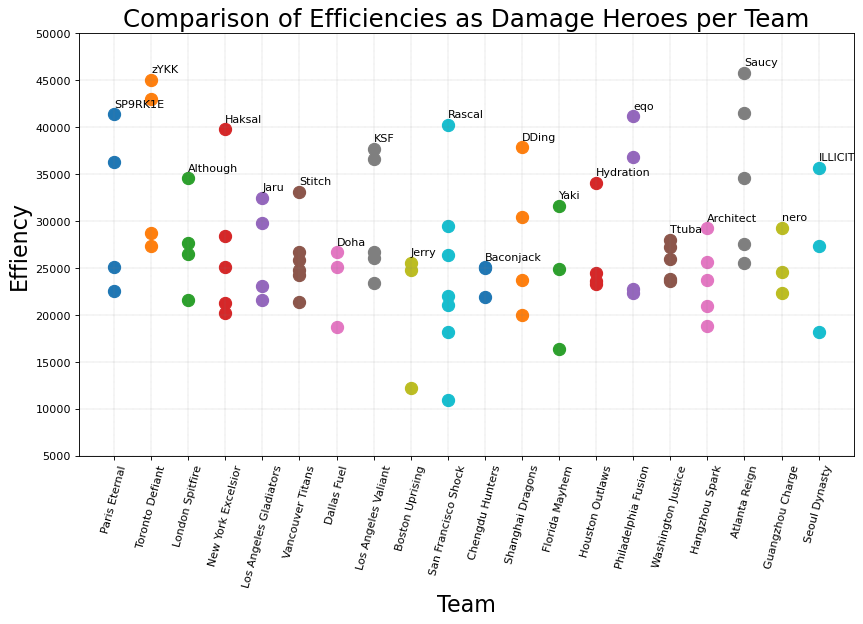

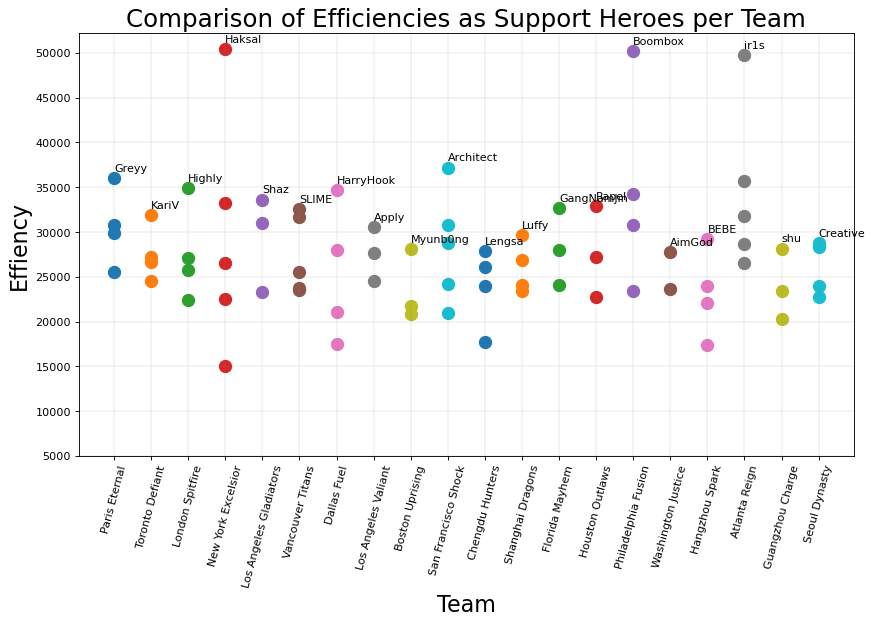

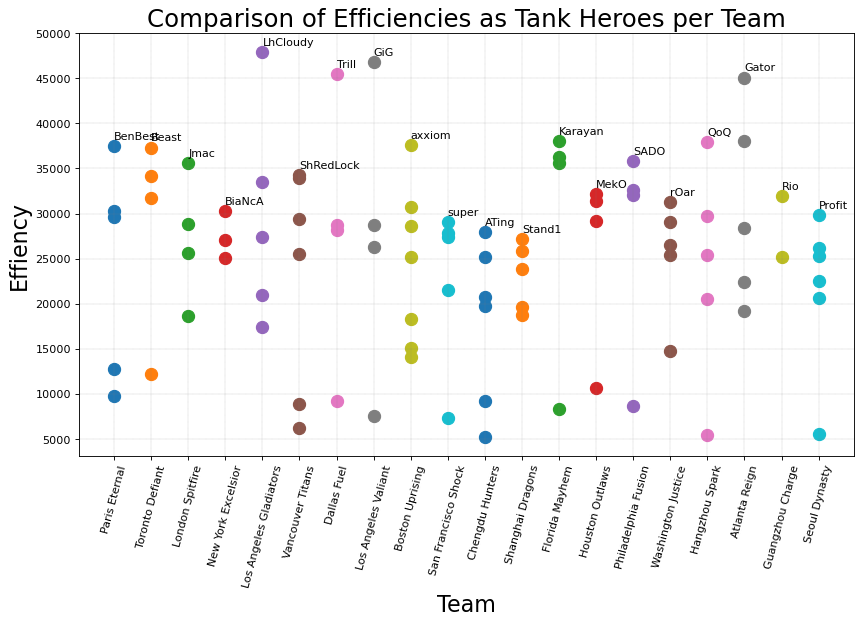

In [8]:
classes = [damagers, supports, tanks]
class_names = ["Damage", "Support", "Tank"]
for curr_class, class_name in zip(classes, class_names):
    # Take rows of only heroes of the current class
    curr_table = average_table.loc[average_table['hero_name'].isin(curr_class)].copy()

    # Define equations we will use to calculate overall efficiency and create efficiency column
    def class_efficiency(row):
        if (class_name == "Damage"):
            return (2*row['Assists'] + 2*row['Barrier Damage Done'] - 1.5*row['Deaths'] + 2.5*row['Eliminations'] + 2*row['All Damage Done']
                    + 2*row['Final Blows'] + row['Healing Done'] + 2*row['Objective Kills'] + row['Objective Time'] + 1.5*row['Ultimates Earned'])
        elif (class_name == "Support"):
            return (2*row['Assists'] + 1.5*row['Barrier Damage Done'] - 2*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
                    + row['Final Blows'] + 2.5*row['Healing Done'] + 1.5*row['Objective Kills'] + 1.5*row['Objective Time'] + 1.5*row['Ultimates Earned'])
        else:
            return (1.5*row['Assists'] + row['Barrier Damage Done'] + 1.5*row['Damage Blocked'] - 3*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
                    + row['Final Blows'] + row['Healing Done'] + 1.5*row['Objective Kills'] + 1.5*row['Objective Time'] + row['Ultimates Earned'])
            
    curr_table['Efficiency'] = curr_table.apply(lambda row: class_efficiency(row), axis=1)

    # Ignore rows with less than 5000 efficiency as that probably means the player only played as the  for a short period of time
    # and drop newly irrelevant columns
    curr_table = curr_table[curr_table.Efficiency > 5000].groupby(['team_name', 'player_name']).mean().reset_index().sort_values('Efficiency', ascending=False)
    curr_table['Efficiency'] = curr_table['Efficiency'].round(decimals = 2)
    best_efficiency_table = curr_table.loc[curr_table.groupby('team_name')['Efficiency'].idxmax()].sort_values('Efficiency', ascending=False)

    # Plot efficiencies of each player for each team
    plots = plt.figure(figsize=(12.5,7), dpi=80).subplots()
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.2)
    for team in teams:
        plots.scatter(curr_table.loc[curr_table['team_name'] == team]['team_name'].tolist(), curr_table.loc[curr_table['team_name'] == team]['Efficiency'].tolist(), label=team, s=120)
    for index, row in  best_efficiency_table.iterrows():
        plots.annotate(row['player_name'], (row['team_name'], row['Efficiency']), xytext=(row['team_name'], row['Efficiency'] + 750))
    plots.set_xticklabels(teams, rotation=75)
    plots.set_xlabel('Team', fontsize=20)
    plots.set_ylabel('Effiency', fontsize=20)
    plots.set_yticks([5000,10000,15000,20000,25000,30000,35000,40000,45000,50000])
    plots.set_title('Comparison of Efficiencies as ' + class_name + ' Heroes per Team', fontsize=22)
    print("\nTop 3 most efficient " + class_name + " players: ")
    for index, row in curr_table.head(3).iterrows():
        print(row['player_name'] + " (" + row['team_name'] + "): " + str(row['Efficiency']))
    

These graphs allow us to easily see the most efficient players for each team on each class. Notably, we can see that one support player in particular stands out as the most efficienct support and damage hero for his team: Haksal. In fact, we could've seen this coming as Haksal, now retired, was regarded as one of the greatest Genji and Brigitte players of all time. His impact as a damage and support character gave New York Excelsior a huge upper hand against their opponents as the year before he had won the OWL's first Rookie of the Year award, and was named both an OWL Role Star and All-Star.

<H3>
    <Strong>
        Hero Picks by the Top 3 Players of each Class
    </Strong>
</H3>

For each class, we found that the most efficient three players are:  
<b>Damage</b>
1. Saucy (Atlanta Reign): 45785.84
2. zYKK (Toronto Defiant): 45013.08
3. Agilities (Toronto Defiant): 42955.20

<b>Support</b>  
1. Haksal (New York Excelsior): 50429.34
2. Boombox (Philadelphia Fusion): 50166.52
3. ir1s (Atlanta Reign): 49762.16

<b>Tank</b>
1. LhCloudy (Los Angeles Gladiators): 47879.26
2. GiG (Los Angeles Valiant): 46805.45
3. Trill (Dallas Fuel): 45493.45

Now, we can find the distribution of hero picks by each player i.e. what percent of in-game time they spend playing each hero.

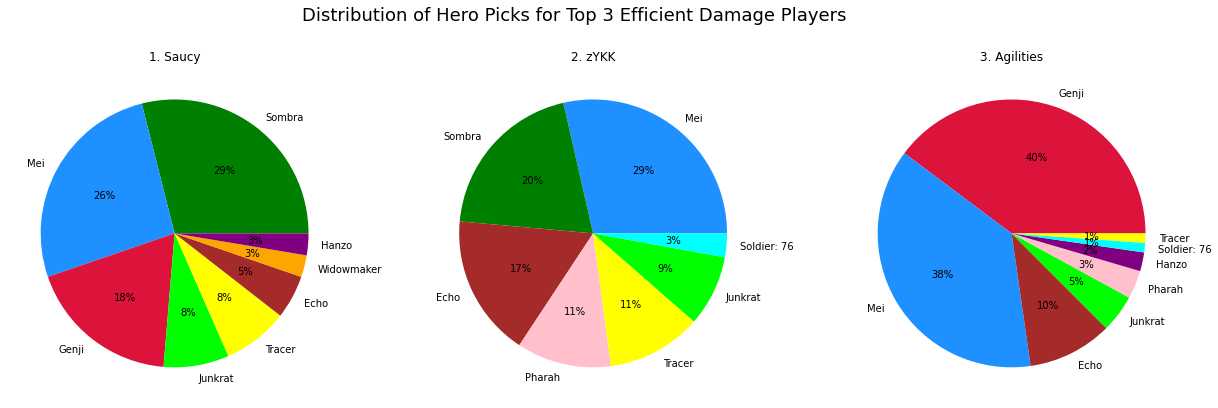

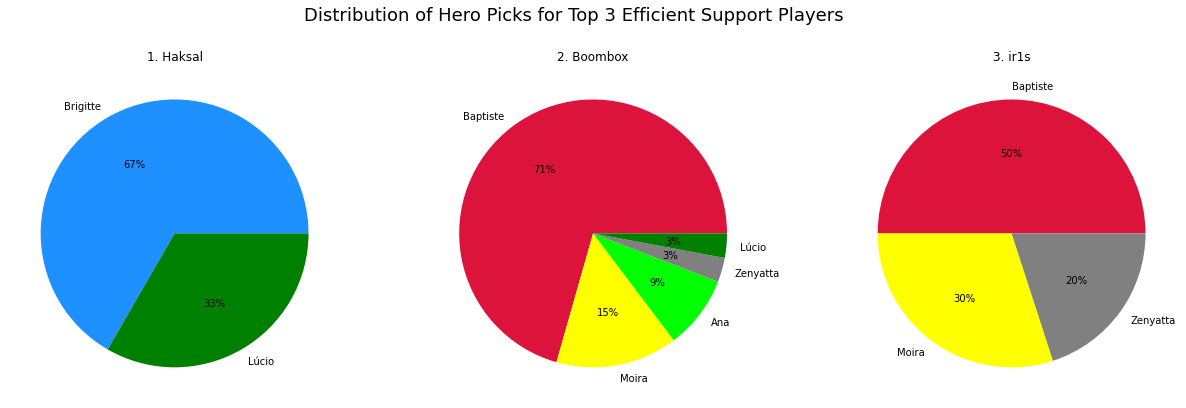

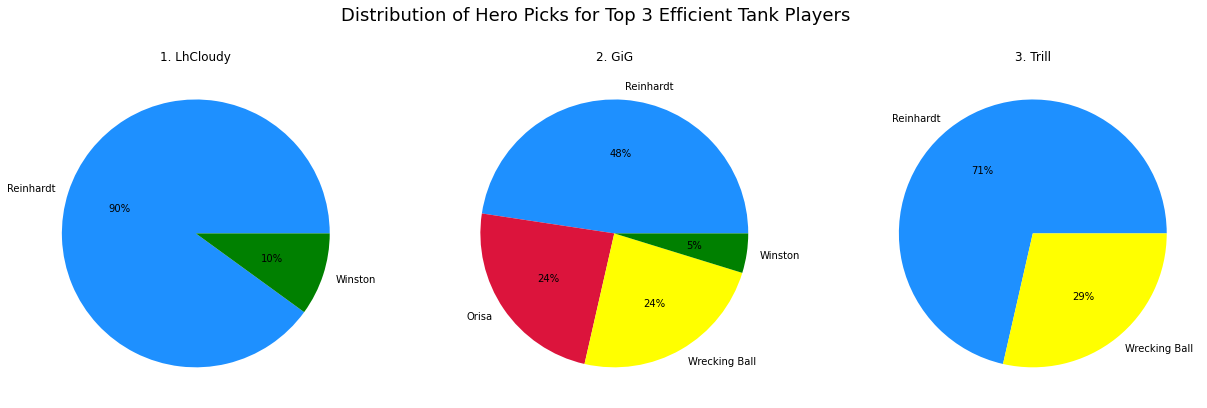

In [9]:
best_damagers = ['Saucy', 'zYKK', 'Agilities']
best_supports = ['Haksal', 'Boombox', 'ir1s']
best_tanks = ['LhCloudy', 'GiG', 'Trill']
best_classes = [best_damagers, best_supports, best_tanks]

colors={'Mei':'dodgerblue', 'Sombra':'green', 'Genji':'crimson', 'Tracer':'yellow', 'Junkrat':'lime', 'Echo':'brown', 'Hanzo':'purple', 'Widowmaker':'orange', 'Pharah':'pink', 'Soldier: 76':'cyan', 'Brigitte':'dodgerblue', 'Lúcio':'green', 'Baptiste':'crimson', 'Moira':'yellow', 'Ana':'lime', 'Zenyatta':'gray',
        'Reinhardt':'dodgerblue', 'Winston':'green', 'Orisa':'crimson', 'Wrecking Ball':'yellow'}
# Plot pie chart for best the distribution of hero picks by the most efficient players for each class
for curr_class, curr_best, class_name in zip(classes, best_classes, class_names):
    curr_table = data[['player_name', 'hero_name']]
    curr_table = curr_table.loc[curr_table['hero_name'].isin(curr_class)].copy()
    curr_table = curr_table.loc[curr_table['player_name'].isin(curr_best)]

    count = 1
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6.6))
    plt.subplots_adjust(wspace=.25)
    fig.suptitle("Distribution of Hero Picks for Top 3 Efficient " + class_name + " Players", fontsize=18, y=.98)
    for player, ax in zip(curr_best, axs.ravel()):
        title = str(count) + '. ' + player
        curr_tab = curr_table.loc[curr_table['player_name'] == player]
        ax = curr_tab['hero_name'].value_counts().plot.pie(title=title, autopct='%1.0f%%', ax=ax, colors=[colors[v] for v in curr_tab['hero_name'].value_counts().keys()])
        ax.set_ylabel('')
        count += 1